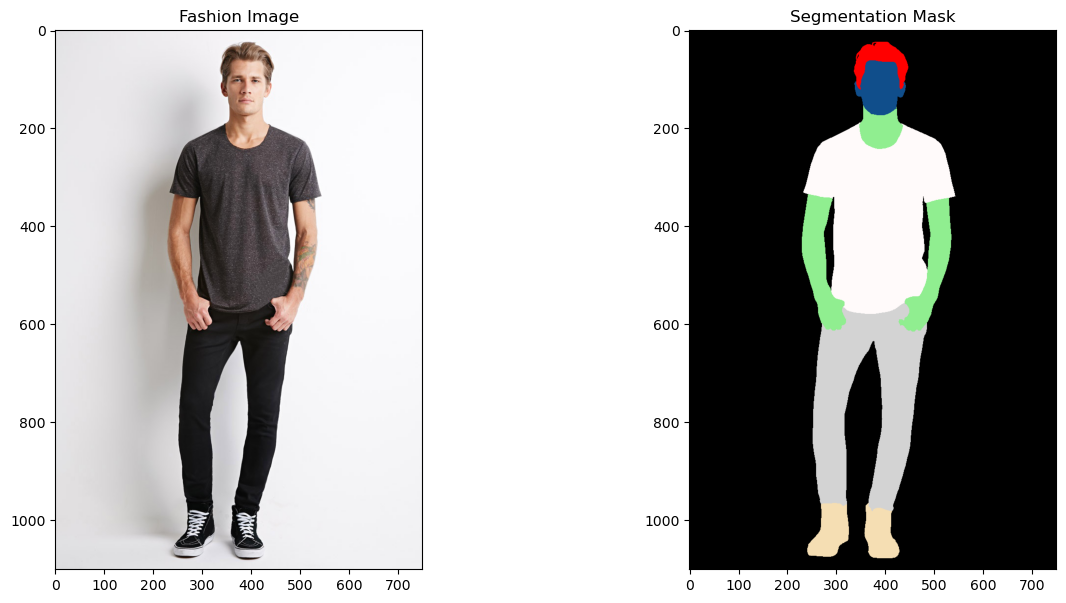

In [3]:
import os
import json
import matplotlib.pyplot as plt
from PIL import Image

# Paths to the dataset directories
image_dir = "images\images"
parsing_dir = "segm\segm"
description_file = "captions.json"

# Load textual descriptions
with open(description_file, 'r') as f:
    descriptions = json.load(f)

# Function to visualize an image and its corresponding segmentation mask
def visualize_sample(image_path, parsing_path):
    image = Image.open(image_path)
    parsing = Image.open(parsing_path)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    ax1.imshow(image)
    ax1.set_title("Fashion Image")
    ax2.imshow(parsing)
    ax2.set_title("Segmentation Mask")
    plt.show()

# Example of visualizing a sample
sample_image = os.path.join(image_dir, "MEN-Denim-id_00000080-01_7_additional.jpg")
sample_parsing = os.path.join(parsing_dir, "MEN-Denim-id_00000080-01_7_additional_segm.png")
visualize_sample(sample_image, sample_parsing)


In [4]:
from torchvision import transforms

# Define transformations
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Apply transformation to a sample image
image = Image.open(sample_image)
transformed_image = transform(image)

 OpenMP Runtime Error
The OpenMP error indicates that your program has linked multiple versions of the OpenMP runtime, which can lead to performance issues or incorrect results. This usually happens when different libraries or components use different versions of OpenMP.

Solutions:

Ensure Single OpenMP Runtime:

Check your project's dependencies to make sure that they all use the same OpenMP runtime. This often involves ensuring that libraries linked against OpenMP are consistent.
Avoid Static Linking:

If possible, avoid static linking of the OpenMP runtime in any libraries. Prefer dynamic linking to avoid multiple runtime instances.
Environment Variable (Temporary Workaround):

As a temporary measure, you can set the environment variable KMP_DUPLICATE_LIB_OK=TRUE to bypass the error. However, this is not recommended as a long-term solution because it can lead to crashes or incorrect results. To set this variable, you can do so in your environment configuration or directly in your script:

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [16]:
from torch.utils.data import Dataset, DataLoader

class FashionDataset(Dataset):
    def __init__(self, image_dir, parsing_dir, transform=None):
        self.image_dir = image_dir
        self.parsing_dir = parsing_dir
        self.transform = transform
        self.image_files = os.listdir(image_dir)
        
        # Synchronize image and parsing files
        self.image_files = [f for f in self.image_files if os.path.exists(os.path.join(parsing_dir, f.replace(".jpg", ".png")))]
        
        if len(self.image_files) == 0:
            raise ValueError("No matching files found between image_dir and parsing_dir")
        
        print(f"Found {len(self.image_files)} matching image and parsing files.")
            
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        parsing_path = os.path.join(self.parsing_dir, self.image_files[idx].replace(".jpg", ".png"))
        
        image = Image.open(image_path).convert("RGB")
        parsing = Image.open(parsing_path)
        
        if self.transform:
            image = self.transform(image)
        
        return image, parsing

# Create dataset and dataloader
dataset = FashionDataset(image_dir, parsing_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)


ValueError: No matching files found between image_dir and parsing_dir

In [17]:
dataset.image_dir

'images\\images'

In [14]:
'WOMEN-Blouses_Shirts-id_00000351-08_2_side.jpg' in dataset.image_files

True

In [12]:
dataset.__len__

<bound method FashionDataset.__len__ of <__main__.FashionDataset object at 0x000001CE43B1EAD0>>

In [6]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Load pre-trained model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Modify the classifier to match the number of classes in the dataset
num_classes = 2  # Fashion item + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to C:\Users\Vinay Kumar Kosgi/.cache\torch\hub\checkpoints\fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:14<00:00, 11.3MB/s] 


In [7]:
import torch
from torch.optim import Adam

# Training loop
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, targets in dataloader:
        images = [image.to(device) for image in images]
        targets = [{"boxes": target["boxes"].to(device), "labels": target["labels"].to(device)} for target in targets]
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
        
        epoch_loss += losses.item()
    
    print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(dataloader)}")

FileNotFoundError: [Errno 2] No such file or directory: 'segm\\segm\\WOMEN-Blouses_Shirts-id_00006380-02_7_additional.png'

In [11]:
for images, target in dataloader :
    print(target)
    for image in images :
        print(image)

FileNotFoundError: [Errno 2] No such file or directory: 'segm\\segm\\WOMEN-Blouses_Shirts-id_00000351-08_2_side.png'